# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [ ]:
#A used car dealership makes money by buying cars at a low price and selling them for more. So, being able to predict a car’s selling
#price is very important. It’s also important to know which cars people want, so they can sell quickly. Things like the buyer’s age, 
#location, and personal preferences play a big role in what cars are in demand.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import set_config
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector

import plotly.express as px

set_config(display="diagram")

In [135]:
df = pd.read_csv('vehicles.csv')


In [136]:
# Data Understanding
df.head(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [138]:
df.duplicated().sum()

0

In [139]:
df.nunique()

id              426880
region             404
price            15655
year               114
manufacturer        42
model            29649
condition            6
cylinders            8
fuel                 5
odometer        104870
title_status         6
transmission         3
VIN             118246
drive                3
size                 4
type                13
paint_color         12
state               51
dtype: int64

In [140]:
missing_val = df.isnull().mean()*100
missing_val

id               0.000000
region           0.000000
price            0.000000
year             0.282281
manufacturer     4.133714
model            1.236179
condition       40.785232
cylinders       41.622470
fuel             0.705819
odometer         1.030735
title_status     1.930753
transmission     0.598763
VIN             37.725356
drive           30.586347
size            71.767476
type            21.752717
paint_color     30.501078
state            0.000000
dtype: float64

In [141]:
# Finding outliers for price col
def outliers_val (df1 , col1):
    factor = 1.5
    Q1 = df1[col1].quantile(.25)
    Q3 = df1[col1].quantile(.75)
    iqr = Q3 - Q1
    lower= Q1 - factor*iqr
    upper= Q3 +factor*iqr
    print( f' lower: { lower }, upper: { upper }')
    return 
outliers_val(df, 'price')

 lower: -24978.625, upper: 57364.375


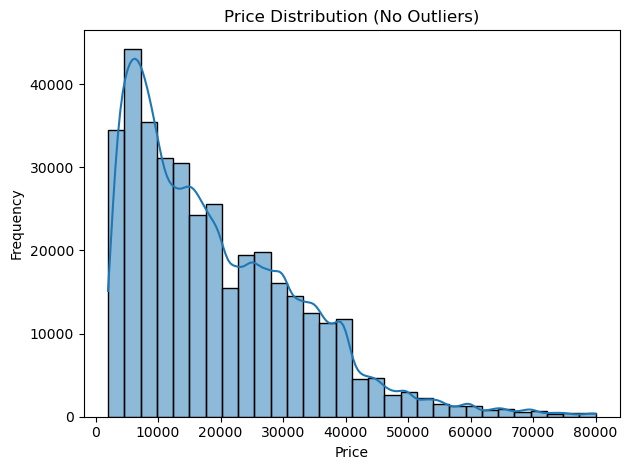

In [142]:
df_clean = df[(df['price'] >= 2000) & (df['price'] <= 80000)]
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(df_clean['price'], bins =30, kde =True, edgecolor = 'black')
plt.title('Price Distribution (No Outliers)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.savefig('plot1.png')
plt.show()


In [145]:
outliers_val(df, 'odometer')

 lower: -106053.75, upper: 277300.25


In [146]:
df_clean = df[(df['odometer'] >=5000)]
df_clean

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
27,7316814884,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,3GTP1VEC4EG551563,NaN,NaN,pickup,white,al
28,7316814758,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,1GCSCSE06AZ123805,NaN,NaN,pickup,blue,al
29,7316814989,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,3GCPWCED5LG130317,NaN,NaN,pickup,red,al
30,7316743432,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,5TFRM5F17HX120972,NaN,NaN,pickup,red,al
31,7316356412,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,NaN,rwd,full-size,truck,black,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426874,7301591199,wyoming,33590,2018.0,lexus,gs 350 sedan 4d,good,6 cylinders,gas,30814.0,clean,automatic,JTHBZ1BLXJA012999,rwd,NaN,sedan,white,wy
426875,7301591192,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,wy
426876,7301591187,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,wy
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,wy


In [147]:
# Check the correlation of the dataset
df.corr()

/var/folders/93/dz45r18s4_j3thqpplfq9g8w0000gn/T/ipykernel_68645/2804339802.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,id,price,year,odometer
id,1.000000,-0.002779,-0.059040,0.010721
price,-0.002779,1.000000,-0.004925,0.010032
year,-0.059040,-0.004925,1.000000,-0.157215
odometer,0.010721,0.010032,-0.157215,1.000000


In [148]:
# There is no observed difference in correlation, indicating that the 'id' does not affect the correlation results. 
# However, the presence of numerous NaNs, nulls, and missing values may be influencing the correlation. 
# In the Data Preparation section, we will clean the data and then recompute the correlation. We start the data preparation by taking a copy of the loaded dataset and dropping null rows


In [149]:
df1 = df.copy().dropna()
df1 = df1.drop('id', axis=1)
df1.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
126,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,68472.0,clean,automatic,1GCWGAFP8J1309579,rwd,full-size,van,white,al
127,auburn,0,2019.0,chevrolet,express cargo van,like new,6 cylinders,gas,69125.0,clean,automatic,1GCWGAFP4K1214373,rwd,full-size,van,white,al
128,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,66555.0,clean,automatic,1GCWGAFPXJ1337903,rwd,full-size,van,white,al
215,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al


/var/folders/93/dz45r18s4_j3thqpplfq9g8w0000gn/T/ipykernel_68645/940729865.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(df1.corr(), annot = True)


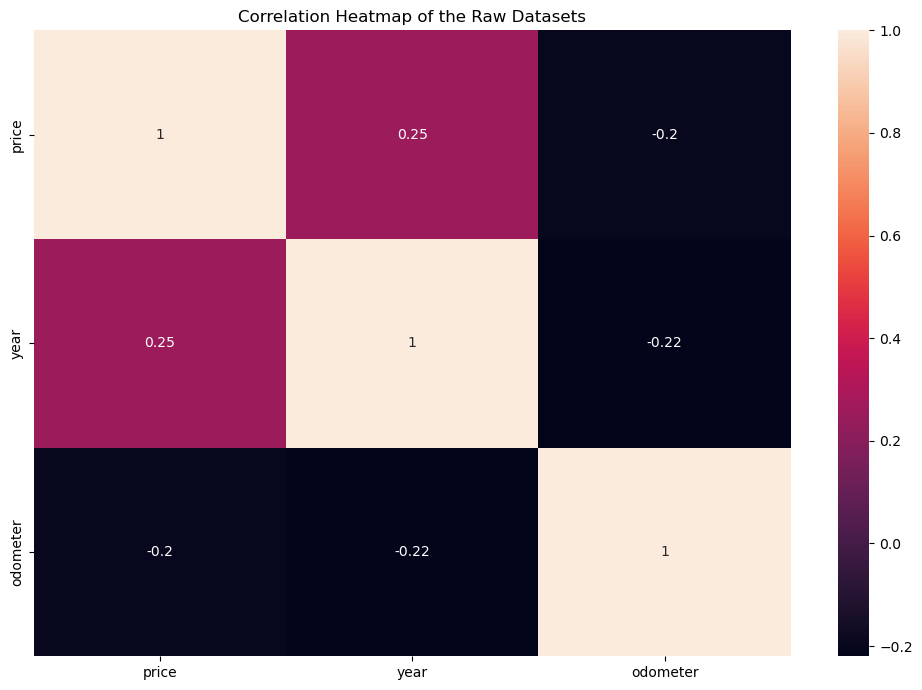

In [150]:
fig, ax = plt.subplots(figsize=(10,7))
plt.rcParams["figure.autolayout"] = True

#create seaborn heatmap
ax = sns.heatmap(df1.corr(), annot = True)

# Adding Title to the Plot
ax.set_title("Correlation Heatmap of the Raw Datasets")
manager = plt.get_current_fig_manager()
manager.full_screen_toggle()
plt.savefig('plot3.png')
plt.show()


In [151]:
#Correlation matrix shows not strong correlation, one would expect a strong correlation between year, odometer and price
# for example, the lower the odometer the higher the price etc

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [152]:
df2 = df.query("price > 0").dropna()
df2

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al
268,7315946365,birmingham,9000,2008.0,mazda,miata mx-5,excellent,4 cylinders,gas,56700.0,clean,automatic,JM1NC25F570128735,rwd,compact,convertible,white,al
337,7315354216,birmingham,8950,2011.0,ford,f-150,excellent,6 cylinders,gas,164000.0,clean,automatic,1FTMF1CM6BKD55331,fwd,full-size,truck,white,al
338,7315349921,birmingham,4000,1972.0,mercedes-benz,benz,fair,6 cylinders,gas,88100.0,clean,automatic,1.14023E+13,rwd,full-size,coupe,silver,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426785,7303314912,wyoming,23495,2015.0,ford,f150 xlt 4x4,like new,8 cylinders,gas,146795.0,clean,automatic,1FTFX1EF5FFC24427,4wd,full-size,truck,black,wy
426788,7303227528,wyoming,12995,2016.0,chevrolet,cruze lt,like new,4 cylinders,gas,61127.0,clean,automatic,1G1BE5SM0G7266569,fwd,compact,sedan,silver,wy
426792,7303114896,wyoming,32999,2014.0,ford,"f350, xlt",excellent,8 cylinders,diesel,154642.0,clean,automatic,1FT8W3DT3EEB41548,4wd,full-size,pickup,brown,wy
426793,7303112347,wyoming,15999,2018.0,chevrolet,"cruze, lt",excellent,4 cylinders,gas,36465.0,clean,automatic,1G1BE5SM7J7133704,fwd,mid-size,sedan,black,wy


In [153]:
data_copy = data.copy().dropna()
data_copy.shape

(34868, 18)

In [154]:
data_copy = data_copy.drop(['id','region','model','VIN'],axis=1)
data_copy

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
126,0,2018.0,chevrolet,like new,6 cylinders,gas,68472.0,clean,automatic,rwd,full-size,van,white,al
127,0,2019.0,chevrolet,like new,6 cylinders,gas,69125.0,clean,automatic,rwd,full-size,van,white,al
128,0,2018.0,chevrolet,like new,6 cylinders,gas,66555.0,clean,automatic,rwd,full-size,van,white,al
215,4000,2002.0,toyota,excellent,4 cylinders,gas,155000.0,clean,automatic,fwd,compact,sedan,blue,al
219,2500,1995.0,bmw,fair,6 cylinders,gas,110661.0,clean,automatic,rwd,mid-size,sedan,white,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426788,12995,2016.0,chevrolet,like new,4 cylinders,gas,61127.0,clean,automatic,fwd,compact,sedan,silver,wy
426792,32999,2014.0,ford,excellent,8 cylinders,diesel,154642.0,clean,automatic,4wd,full-size,pickup,brown,wy
426793,15999,2018.0,chevrolet,excellent,4 cylinders,gas,36465.0,clean,automatic,fwd,mid-size,sedan,black,wy
426833,6800,1997.0,jaguar,good,8 cylinders,gas,69550.0,clean,automatic,rwd,compact,convertible,white,wy


In [155]:
# Check on which columns are nulls
data_copy.isnull().sum()

price           0
year            0
manufacturer    0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64

In [156]:
# There are no null values, but it’s important to review the columns that contain zero values. Some records clearly
# have zeros that may need further investigation.

In [157]:
zero_col = data_copy.eq(0).any()
zero_col

price            True
year            False
manufacturer    False
condition       False
cylinders       False
fuel            False
odometer         True
title_status    False
transmission    False
drive           False
size            False
type            False
paint_color     False
state           False
dtype: bool

In [158]:
# Get the count of zeros in column 'price' 
count = (data_copy['price'] == 0).sum()
print('Count of zeros in Column  price : ', count)

Count of zeros in Column  price :  2372


In [159]:
# Get the count of zeros in column 'odometer' 
count = (data_copy['odometer'] == 0).sum()
print('Count of zeros in Column  odometer : ', count)

Count of zeros in Column  odometer :  81


In [160]:
# Removing records with zero for odometer and prices
# Remove rows with all 0s in a Dataframe
data_copy.drop(data_copy[data_copy['price'] == 0].index, inplace = True)
data_copy.drop(data_copy[data_copy['odometer'] == 0].index, inplace = True)
data_copy

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
215,4000,2002.0,toyota,excellent,4 cylinders,gas,155000.0,clean,automatic,fwd,compact,sedan,blue,al
219,2500,1995.0,bmw,fair,6 cylinders,gas,110661.0,clean,automatic,rwd,mid-size,sedan,white,al
268,9000,2008.0,mazda,excellent,4 cylinders,gas,56700.0,clean,automatic,rwd,compact,convertible,white,al
337,8950,2011.0,ford,excellent,6 cylinders,gas,164000.0,clean,automatic,fwd,full-size,truck,white,al
338,4000,1972.0,mercedes-benz,fair,6 cylinders,gas,88100.0,clean,automatic,rwd,full-size,coupe,silver,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426785,23495,2015.0,ford,like new,8 cylinders,gas,146795.0,clean,automatic,4wd,full-size,truck,black,wy
426788,12995,2016.0,chevrolet,like new,4 cylinders,gas,61127.0,clean,automatic,fwd,compact,sedan,silver,wy
426792,32999,2014.0,ford,excellent,8 cylinders,diesel,154642.0,clean,automatic,4wd,full-size,pickup,brown,wy
426793,15999,2018.0,chevrolet,excellent,4 cylinders,gas,36465.0,clean,automatic,fwd,mid-size,sedan,black,wy


In [161]:
# Lets look at the Correlation after some data manipulation
data_copy.corr()

/var/folders/93/dz45r18s4_j3thqpplfq9g8w0000gn/T/ipykernel_68645/2257132455.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_copy.corr()


,price,year,odometer
price,1.000000,0.317258,-0.233163
year,0.317258,1.000000,-0.212234
odometer,-0.233163,-0.212234,1.000000


In [162]:
# The dataset now has no missing values, allowing us to continue reviewing the records to identify
# any additional attributes that may have little impact on determining what makes a car more or less expensive. The correlation between price, odometer, and year is not strong overall, with only year showing a positive relationship to price.

In [163]:
# Remove these features above from the datasets paint_color, manufacturer, model, cylinders,type, transmission and title_status

data_copy.drop(['state', 'paint_color', 'manufacturer', 'cylinders', 'type', 'transmission', 'title_status'], axis=1,  inplace=True)
data_copy.head(5)

,price,year,condition,fuel,odometer,drive,size
215,4000,2002.0,excellent,gas,155000.0,fwd,compact
219,2500,1995.0,fair,gas,110661.0,rwd,mid-size
268,9000,2008.0,excellent,gas,56700.0,rwd,compact
337,8950,2011.0,excellent,gas,164000.0,fwd,full-size
338,4000,1972.0,fair,gas,88100.0,rwd,full-size


In [164]:
# Let's reviwed the unique values for the features that we are planning to keep for the model

In [165]:
data_copy['condition'].value_counts()

excellent    18209
good          9762
like new      3770
fair           487
new            169
salvage         35
Name: condition, dtype: int64

In [166]:
data_copy['fuel'].value_counts()

gas         29130
diesel       2805
hybrid        389
electric       76
other          32
Name: fuel, dtype: int64

In [167]:
data_copy['drive'].value_counts()

4wd    15248
fwd    10369
rwd     6815
Name: drive, dtype: int64

In [168]:
data_copy['size'].value_counts()

full-size      19118
mid-size        8920
compact         3809
sub-compact      585
Name: size, dtype: int64

In [169]:
#create categorical variables and drop some variables
model_data_df=pd.get_dummies(data_copy, columns=["condition","fuel","size", "drive"])
model_data_df.head()

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,...,fuel_gas,fuel_hybrid,fuel_other,size_compact,size_full-size,size_mid-size,size_sub-compact,drive_4wd,drive_fwd,drive_rwd
215,4000,2002.0,155000.0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
219,2500,1995.0,110661.0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
268,9000,2008.0,56700.0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
337,8950,2011.0,164000.0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
338,4000,1972.0,88100.0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1


In [170]:
#Let's look at the correlation for the final dataset
model_data_df.corr()

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,...,fuel_gas,fuel_hybrid,fuel_other,size_compact,size_full-size,size_mid-size,size_sub-compact,drive_4wd,drive_fwd,drive_rwd
price,1.000000,0.317258,-0.233163,-0.024179,-0.117517,-0.055432,0.147255,0.076584,-0.030312,0.420564,...,-0.379040,-0.038859,-0.011298,-0.196132,0.307108,-0.178640,-0.061325,0.294039,-0.372592,0.066291
year,0.317258,1.000000,-0.212234,0.081343,-0.166194,-0.144118,0.134789,0.044497,-0.013736,0.025427,...,-0.034400,0.020805,-0.016149,0.013967,0.005844,-0.012437,-0.013661,0.134664,0.038940,-0.209552
odometer,-0.233163,-0.212234,1.000000,-0.033959,0.117778,0.091095,-0.117267,-0.036769,0.029717,0.046102,...,-0.037938,-0.003167,0.007467,-0.056646,0.066543,-0.030012,-0.008237,0.017157,-0.008741,-0.011012
condition_excellent,-0.024179,0.081343,-0.033959,1.000000,-0.139705,-0.742491,-0.410360,-0.081891,-0.037190,-0.032248,...,0.027311,0.011756,0.006004,0.066284,-0.090548,0.039500,0.041811,0.047806,0.031752,-0.094915
condition_fair,-0.117517,-0.166194,0.117778,-0.139705,1.000000,-0.081023,-0.044780,-0.008936,-0.004058,-0.017246,...,0.015580,0.000370,0.012270,0.011658,-0.021170,0.017066,-0.007209,-0.023857,0.013753,0.013483
condition_good,-0.055432,-0.144118,0.091095,-0.742491,-0.081023,1.000000,-0.237991,-0.047494,-0.021569,0.048475,...,-0.031143,-0.030312,-0.005635,-0.078194,0.110753,-0.056740,-0.029843,-0.027426,-0.060258,0.102579
condition_like new,0.147255,0.134789,-0.117267,-0.410360,-0.044780,-0.237991,1.000000,-0.026249,-0.011921,-0.011315,...,-0.002916,0.018365,-0.005270,0.001861,-0.007106,0.013166,-0.022409,-0.027076,0.029430,-0.000519
condition_new,0.076584,0.044497,-0.036769,-0.081891,-0.008936,-0.047494,-0.026249,1.000000,-0.002379,-0.003987,...,-0.005372,0.027432,-0.002275,0.008183,-0.007506,-0.001421,0.012716,0.007331,0.007317,-0.017358
condition_salvage,-0.030312,-0.013736,0.029717,-0.037190,-0.004058,-0.021569,-0.011921,-0.002379,1.000000,-0.006773,...,0.004855,0.005005,-0.001033,0.011345,-0.014569,0.007095,0.002601,-0.002738,0.007672,-0.005428
fuel_diesel,0.420564,0.025427,0.046102,-0.032248,-0.017246,0.048475,-0.011315,-0.003987,-0.006773,1.000000,...,-0.913912,-0.033902,-0.009670,-0.107135,0.237822,-0.172572,-0.040879,0.174996,-0.190712,0.003926


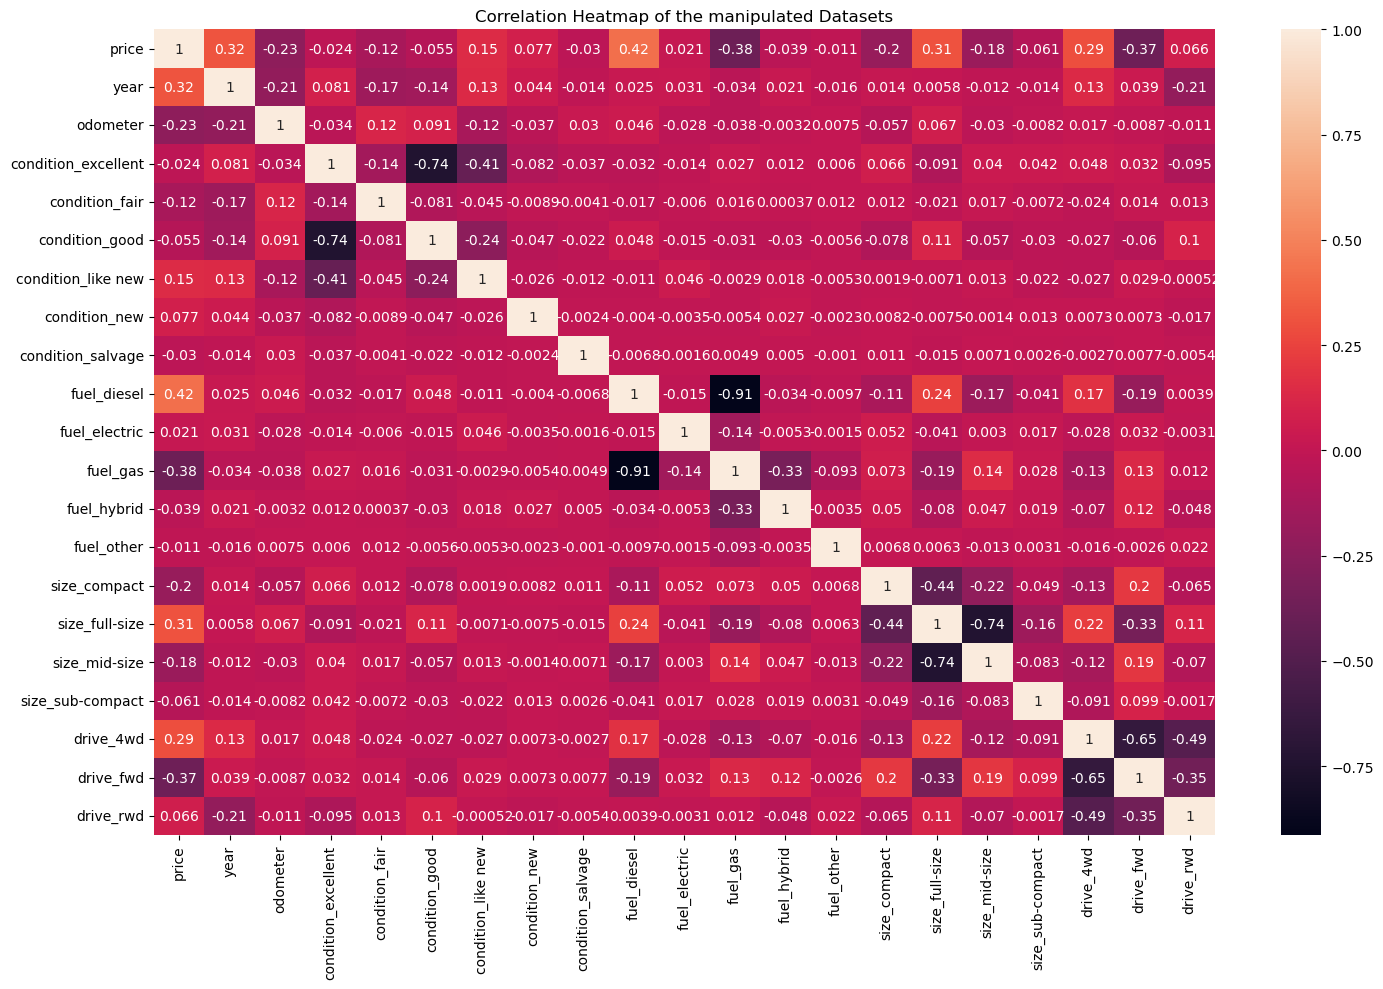

In [171]:
# Now lets look at the heatmap for the final data set

fig, ax = plt.subplots(figsize=(15,10))
plt.rcParams["figure.autolayout"] = True

#create seaborn heatmap
ax = sns.heatmap(model_data_df.corr(), annot = True)

# Adding Title to the Plot
ax.set_title("Correlation Heatmap of the manipulated Datasets")
manager = plt.get_current_fig_manager()
manager.full_screen_toggle()
plt.savefig('plot4.png')
plt.show()


In [172]:
# Among the categorical variables created, the strongest correlation with price is for fuel_diesel.
# When examining the correlations with price, most values are negative. 
# The only attributes showing positive correlations with price are year,
# condition_like_new, fuel_diesel, size_full-size, and drive_4wd. 
# Although these correlations are positive, none are particularly 
# strong—the highest is for fuel_diesel, but even this value is below 0.85. 
# Because of this, no variables should be removed solely based on these correlation results.

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [173]:
# Model1 application will be created using the full set of features (i.e.,year,condition,fuel,odometer,drive and size) in the final dataset
X = model_data_df.drop(['price'], axis = 1)
y = model_data_df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
model=LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)
train_predictions=model.predict(X_train)
# Compute Accuracy and RMSE to training model
score = model.score(X_train, y_train)
print("Accuracy: ",  round(score*100, 2))
print("RMSE:     ",np.sqrt(mean_squared_error(y_train,train_predictions)))
# Using the model to make predictions of Price on the test set:
test_predictions=model.predict(X_test)
# Compute Accuracy and RMSE to test model
score = model.score(X_test, y_test)
print("Accuracy: ", round(score*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y_test,test_predictions)), 2))




Accuracy:  44.54
RMSE:      9846.098980982806
Accuracy:  43.09
RMSE:      9941.12


In [174]:
#Model1 application will be created using odometer and year in the final dataset

new_car_data_df = model_data_df.copy()
new_car_data_df

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,...,fuel_gas,fuel_hybrid,fuel_other,size_compact,size_full-size,size_mid-size,size_sub-compact,drive_4wd,drive_fwd,drive_rwd
215,4000,2002.0,155000.0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
219,2500,1995.0,110661.0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
268,9000,2008.0,56700.0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
337,8950,2011.0,164000.0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
338,4000,1972.0,88100.0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426785,23495,2015.0,146795.0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0
426788,12995,2016.0,61127.0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,1,0
426792,32999,2014.0,154642.0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
426793,15999,2018.0,36465.0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0


In [175]:
# Remove records with Odometer and Price less than 5000
new_car_data_df1 = new_car_data_df.query("odometer > 5000 and price > 2000")
new_car_data_df1

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,...,fuel_gas,fuel_hybrid,fuel_other,size_compact,size_full-size,size_mid-size,size_sub-compact,drive_4wd,drive_fwd,drive_rwd
215,4000,2002.0,155000.0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
219,2500,1995.0,110661.0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
268,9000,2008.0,56700.0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
337,8950,2011.0,164000.0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
338,4000,1972.0,88100.0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426785,23495,2015.0,146795.0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0
426788,12995,2016.0,61127.0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,1,0
426792,32999,2014.0,154642.0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
426793,15999,2018.0,36465.0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0


In [177]:
#Model2 application will be created using the features that have a better correlation with price in the dataset with "odometer > 5000 and price > 5000". These features are odometer, year, fuel_diesel, drive_4wd and size_full-size
# Create a model using Odometer, Year, fuel_diesel, drive_4wd and size_full-size for Price Prediction
# These features are the ones that have a positive correlation with car price
X2 = new_car_data_df1[['odometer', 'year', 'fuel_diesel', 'drive_4wd', 'size_full-size']]
y2 = new_car_data_df1.price
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.3, random_state = 0)
model2=LinearRegression(fit_intercept=False)
model2.fit(X2_train, y2_train)
print("Coefficient of the model: ",model2.coef_)
print("Intercept of the model: ", model2.intercept_)

#Let compute the predictions for the entire set of inputs
train2_predictions=model2.predict(X2_train)

#Compute Accuracy and RMSE to training model
score2 = model2.score(X2_train, y2_train)
print("Accuracy: ", round(score2*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y2_train,train2_predictions)), 2))

# Using the model to make predictions of Price on the test set:
test2_predictions=model2.predict(X2_test)

# Compute Accuracy and RMSE to test model
score2 = model2.score(X2_test, y2_test)
print("Accuracy: ", round(score2*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y2_test,test2_predictions)), 2))

Coefficient of the model:  [-4.14707635e-02  7.45460862e+00  1.58021264e+04  5.74447900e+03
  4.83986127e+03]
Intercept of the model:  0.0
Accuracy:  37.01
RMSE:      10030.14
Accuracy:  41.91
RMSE:      9858.27


In [178]:
#Use the sklearn.inspection modules implementation of permutation_
# importance to investigate the importance of different features to your regression models

model2R = Ridge(alpha=1e-2).fit(X2_train, y2_train)
model2R.score(X2_test, y2_test)

0.46669699007915566

In [179]:
#  permutation_importance function to probe which features are most predictive
r2 = permutation_importance(model2R, X2_test, y2_test, n_repeats=30, random_state=0)
# mean values for permutation_importance
perm_df2 = pd.Series(r2.importances_mean, index=X2_test.columns).sort_values(ascending=False)
perm_df2

fuel_diesel       0.249858
year              0.158676
odometer          0.110974
drive_4wd         0.075069
size_full-size    0.065896
dtype: float64

In [180]:
#Model 3 application will be created using the features that have a better correlation with price in the dataset with "odometer > 5000 and price > 5000" and year > 1990. These features are odometer, year, fuel_diesel, drive_4wd and size_full-size
# Create a new dataframe with used cars from 1990 onwards
new_car_data_1990_df = new_car_data_df1.query("year > 1990")
new_car_data_1990_df.head()

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,...,fuel_gas,fuel_hybrid,fuel_other,size_compact,size_full-size,size_mid-size,size_sub-compact,drive_4wd,drive_fwd,drive_rwd
215,4000,2002.0,155000.0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
219,2500,1995.0,110661.0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
268,9000,2008.0,56700.0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
337,8950,2011.0,164000.0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
346,98900,2001.0,20187.0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1


In [184]:
# Create a model using Odometer, Year, fuel_diesel, drive_4wd and size_full-size for Price Prediction
# These features are the ones that have a positive correlation with car price
X3 = new_car_data_1990_df[['odometer', 'year', 'fuel_diesel', 'drive_4wd', 'size_full-size']]
y3 = new_car_data_1990_df.price
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.3, random_state = 0)
model3=LinearRegression(fit_intercept=False)
model3.fit(X3_train, y3_train)
print("Coefficient of the model: ",model3.coef_)
print("Intercept of the model: ", model3.intercept_)

#Let compute the predictions for the entire set of inputs
train3_predictions=model3.predict(X3_train)

#Compute Accuracy and RMSE to training model
score3 = model3.score(X3_train, y3_train)
print("Accuracy: ", round(score7*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y3_train,train3_predictions)), 2))

# Using the model to make predictions of Price on the test set:
test3_predictions=model3.predict(X3_test)

# Compute Accuracy and RMSE to test model
score3 = model3.score(X3_test, y3_test)
print("Accuracy: ", round(score3*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y3_test,test3_predictions)), 2))

Coefficient of the model:  [-9.10842278e-02  9.95567243e+00  1.68299053e+04  5.98076769e+03
  5.26368891e+03]
Intercept of the model:  0.0
Accuracy:  46.92
RMSE:      8930.03
Accuracy:  46.92
RMSE:      9380.73


In [185]:
model3R = Ridge(alpha=1e-2).fit(X3_train, y3_train)
model3R.score(X3_test, y3_test)

0.5556256673558525

In [186]:
#  permutation_importance function to probe which features are most predictive
r3 = permutation_importance(model3R, X3_test, y3_test, n_repeats=30, random_state=0)
# mean values for permutation_importance
perm_df3 = pd.Series(r3.importances_mean, index=X3_test.columns).sort_values(ascending=False)
perm_df3

fuel_diesel       0.264404
year              0.240902
odometer          0.168684
drive_4wd         0.080742
size_full-size    0.066475
dtype: float64

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [ ]:
# Model 3 is currently the recommended model based on their relative accuracy and stability.
#Although predictive performance can be further improved, these results provide a solid starting 
#point for building tools to estimate used car prices and inform business decisions.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.